Here we attempt to recreate the analysis in the post https://www.countbayesie.com/blog/2022/1/9/is-december-getting-warmer-modeling-weather-data-in-nj

First, we recreate the analysis using GLM in statsmodels. The we try to do the same in PyMC.

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

import arviz as az
import pymc as pm

# Load Data

The data comes from the National Oceanic and Atomspheric Administration (NOAA), nearby Newark Liberty International Airport:

In [2]:
df = (
    pd.read_csv("../data/2845651.csv")[["DATE", "TMAX"]]
    .rename(columns={"TMAX": "temp"})
    .astype({"DATE": 'datetime64[ns]'})
    .dropna()  # data has NaNs. I couldn't care less for this task.
    .set_index("DATE")
    .query("DATE >= '1940-01-01'")
)
print("Shape:", df.shape)
df.head()

Shape: (29964, 1)


,temp
DATE,
1940-01-01,24.0
1940-01-02,29.0
1940-01-03,32.0
1940-01-04,32.0
1940-01-05,29.0


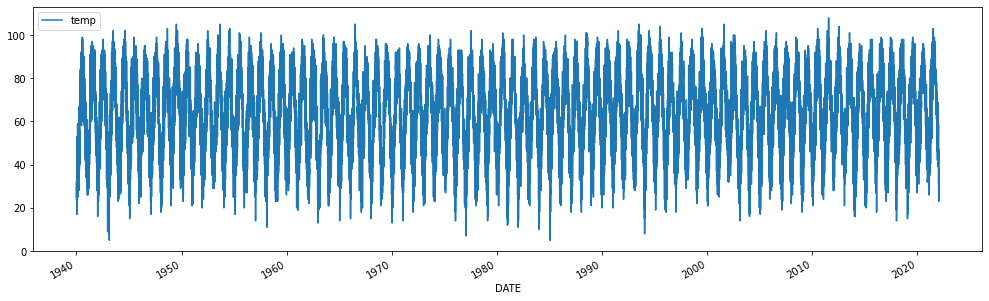

In [3]:
df.plot(figsize=(17,5));

Let's transform the dataset to the following format for convenience:

In [4]:
w_df = df.assign(
    year=lambda df: df.index.year - df.index.year.min() 
)
w_df

,temp,year
DATE,,
1940-01-01,24.0,0
1940-01-02,29.0,0
1940-01-03,32.0,0
1940-01-04,32.0,0
1940-01-05,29.0,0
...,...,...
2022-01-10,38.0,82
2022-01-11,23.0,82
2022-01-12,40.0,82


# GLM/Statsmodels

## Model 1. Linear Regression with 1 Coeff

In [5]:
X_1_df = w_df[["year"]].assign(const=1.0)
print(X_1_df.shape)
X_1_df.head()

(29964, 2)


,year,const
DATE,,
1940-01-01,0,1.0
1940-01-02,0,1.0
1940-01-03,0,1.0
1940-01-04,0,1.0
1940-01-05,0,1.0


In [6]:
year_model = sm.GLM(
    w_df.temp, 
    X_1_df
).fit()
year_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   temp   No. Observations:                29964
Model:                            GLM   Df Residuals:                    29962
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          356.69
Method:                          IRLS   Log-Likelihood:            -1.3056e+05
Date:                Thu, 20 Jan 2022   Deviance:                   1.0687e+07
Time:                        22:27:22   Pearson chi2:                 1.07e+07
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001711
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0330      0.005      7.164      0.000       0.024       0.042
const         62.0004      0.216    286.743      0.000      61.577      62.424
==============================================================================
"""

We get the same results as in the blog post.

## Model 2. Monthly Dummies

In [8]:
X_2_df = pd.concat([
    w_df[["year"]],
    pd.get_dummies(w_df.index.month, prefix="month").set_index(w_df.index)
], axis=1)
print(X_2_df.shape)
X_2_df.head()

(29964, 13)


,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1940-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-02,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-03,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-04,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-05,0,1,0,0,0,0,0,0,0,0,0,0,0


In [9]:
monthly_model = sm.GLM(
    w_df.temp, 
    X_2_df
).fit()
monthly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   temp   No. Observations:                29964
Model:                            GLM   Df Residuals:                    29951
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                          82.323
Method:                          IRLS   Log-Likelihood:            -1.0859e+05
Date:                Thu, 20 Jan 2022   Deviance:                   2.4657e+06
Time:                        22:34:16   Pearson chi2:                 2.47e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9646
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0338      0.002     15.265      0.000       0.029       0.038
month_1       37.6048      0.201    187.243      0.000      37.211      37.998
month_2       40.1907      0.209    192.557      0.000      39.782      40.600
month_3       48.9239      0.201    243.341      0.000      48.530      49.318
month_4       60.5373      0.204    297.163      0.000      60.138      60.937
month_5       70.8905      0.201    352.600      0.000      70.496      71.285
month_6       80.0804      0.204    393.095      0.000      79.681      80.480
month_7       84.9849      0.201    422.704      0.000      84.591      85.379
month_8       82.9715      0.201    412.690      0.000      82.577      83.366
month_9       75.9495      0.204    372.818      0.000      75.550      76.349
month_10      64.9762      0.201    323.183      0.000      64.582      65.370
month_11      53.3166      0.204    261.718      0.000      52.917      53.716
month_12      42.1072      0.201    209.419      0.000      41.713      42.501
==============================================================================
"""

Again, looks exactly the same as the blog post. All values have very small p-value, hence we consider them 'significant'

## Model 3. Year * Month Dummy Interaction

The hypothesis I want to model now is that each month of the year is changing each year in a different way. So far we still have only modeled annual changes but can't be sure if Decembers are getting warmer or if maybe just the Summer months are doing most of the heavy lifting here.

For our next model we will model the interactions of each month with each year. An interaction is just literally the month_var * year. This will allow us to model how each month changes each year. We'll also still be learning a year coefficient since this will let us know if there is a general trend across all months.

In [10]:
X_3_df = pd.concat([
    # year
    w_df[["year"]],
    
    # dummies for months
    pd.get_dummies(w_df.index.month, prefix="month").set_index(w_df.index),

    # dummies for month_dummy * year effects
    pd.get_dummies(w_df.index.month, prefix="month_i").set_index(w_df.index).multiply(w_df.year, axis=0)
], axis=1)

print(X_3_df.shape)
X_3_df.head()

(29964, 25)


,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_i_3,month_i_4,month_i_5,month_i_6,month_i_7,month_i_8,month_i_9,month_i_10,month_i_11,month_i_12
DATE,,,,,,,,,,,,,,,,,,,,,
1940-01-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-02,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-03,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-04,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-05,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
i_monthly_model = sm.GLM(w_df.temp, X_3_df).fit()
i_monthly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   temp   No. Observations:                29964
Model:                            GLM   Df Residuals:                    29940
Model Family:                Gaussian   Df Model:                           23
Link Function:               identity   Scale:                          82.229
Method:                          IRLS   Log-Likelihood:            -1.0857e+05
Date:                Thu, 20 Jan 2022   Deviance:                   2.4619e+06
Time:                        22:34:32   Pearson chi2:                 2.46e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9648
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0312      0.002     15.296      0.000       0.027       0.035
month_1       37.5010      0.355    105.498      0.000      36.804      38.198
month_2       39.4637      0.373    105.727      0.000      38.732      40.195
month_3       48.2978      0.356    135.498      0.000      47.599      48.996
month_4       60.4625      0.362    166.867      0.000      59.752      61.173
month_5       71.1667      0.356    199.656      0.000      70.468      71.865
month_6       80.4130      0.362    221.928      0.000      79.703      81.123
month_7       85.1367      0.356    238.849      0.000      84.438      85.835
month_8       82.9608      0.356    232.744      0.000      82.262      83.659
month_9       76.2685      0.362    210.490      0.000      75.558      76.979
month_10      66.1811      0.356    185.669      0.000      65.482      66.880
month_11      53.7561      0.362    148.359      0.000      53.046      54.466
month_12      40.8947      0.357    114.708      0.000      40.196      41.593
month_i_1      0.0051      0.007      0.704      0.481      -0.009       0.019
month_i_2      0.0205      0.008      2.697      0.007       0.006       0.035
month_i_3      0.0180      0.007      2.472      0.013       0.004       0.032
month_i_4      0.0044      0.007      0.594      0.553      -0.010       0.019
month_i_5     -0.0043      0.007     -0.588      0.557      -0.019       0.010
month_i_6     -0.0057      0.007     -0.767      0.443      -0.020       0.009
month_i_7     -0.0012      0.007     -0.166      0.868      -0.015       0.013
month_i_8      0.0028      0.007      0.385      0.700      -0.011       0.017
month_i_9     -0.0053      0.007     -0.722      0.471      -0.020       0.009
month_i_10    -0.0272      0.007     -3.736      0.000      -0.041      -0.013
month_i_11    -0.0083      0.007     -1.124      0.261      -0.023       0.006
month_i_12     0.0325      0.007      4.459      0.000       0.018       0.047
==============================================================================
"""

The results are just like in the blog post.

Notice the p-values for `month_i_12`, `month_i_10` and `month_i_7`.

* There's an increase of 0.0312 every year. So it's kinda getting warmer
* July is warming up as the year goes, with coeff month_7_i = -0.0012 (doesn't change the base rate of 0.0312)
* October feels the same pretty much, month_10_i = -0.0272 (it compensates the yearly growth 0.0312; 0.0312 -0.0272=0.004)
* December month_12_i is warmer definitely (p_value, low std.err, 0.0312+0.0325)


Based on our model the average December day today in 2021 should be about 46F while the average day in March in 1940 was 48F. In 30 more years, assuming the same constant rate of change (which is a big assumption in a changing world) Decembers will feel like March did to my grandparents.

# PyMC

## Model 1. Linear Regression with 1 Coeff

In [13]:
# not gonna use intercept from here...
print(X_1_df.shape)
X_1_df.head()

(29964, 2)


,year,const
DATE,,
1940-01-01,0,1.0
1940-01-02,0,1.0
1940-01-03,0,1.0
1940-01-04,0,1.0
1940-01-05,0,1.0


In [14]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", lam=0.01)
    intercept = pm.Normal("Intercept", 1.0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    likelihood = pm.Normal("y", 
                           mu=intercept + x_coeff * X_1_df.year.values, 
                           sigma=sigma, 
                           observed=w_df.temp)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vshulyak/opt/miniconda3/envs/intuitive_bayes/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, x]
/Users/vshulyak/opt/miniconda3/envs/intuitive_bayes/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8982, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
az.summary(idata, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,18.8888,0.0767,18.7520,19.0347,0.0023,0.0016,1139.6662,975.8418,1.0005
Intercept,61.9951,0.2146,61.6022,62.4053,0.0068,0.0048,985.3403,990.7668,1.0026
x,0.0330,0.0046,0.0240,0.0412,0.0001,0.0001,999.7810,1096.8803,1.0033


**Result:** The estimated coefficient is really close to the coeff from GLM (which was = 0.0330)

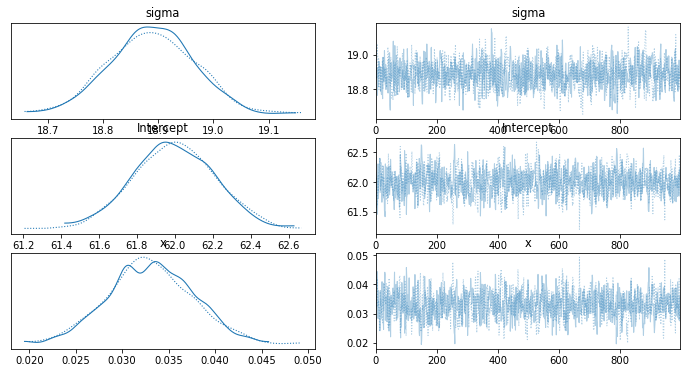

In [16]:
az.plot_trace(idata);

## Model 2. Monthly Dummies

In [17]:
print(X_2_df.shape)
X_2_df.head()

(29964, 13)


,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1940-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-02,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-03,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-04,0,1,0,0,0,0,0,0,0,0,0,0,0
1940-01-05,0,1,0,0,0,0,0,0,0,0,0,0,0


In [18]:
month_vars = list(X_2_df.columns[X_2_df.columns.str.startswith("month_")])
month_vars

['month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [19]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", lam=0.01)
    year_coeff = pm.Normal("year", 0.0, sigma=20)
    month_coeff = pm.Normal("month", 0.0, sigma=20, shape=len(month_vars))

    mu = year_coeff * X_2_df.year.values + pm.math.dot(X_2_df[month_vars].values, month_coeff)

    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=w_df.temp)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vshulyak/opt/miniconda3/envs/intuitive_bayes/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, year, month]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


In [20]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,9.073,0.036,9.007,9.143,0.001,0.000,3669.602,1450.025,1.004
year,0.034,0.002,0.030,0.038,0.000,0.000,1023.805,1450.795,1.001
month[0],37.590,0.201,37.223,37.968,0.005,0.003,1725.386,1695.897,1.000
month[1],40.179,0.201,39.759,40.516,0.005,0.003,1904.361,1543.288,1.001
month[2],48.909,0.204,48.513,49.255,0.004,0.003,2388.433,1604.311,1.000
month[3],60.524,0.198,60.150,60.886,0.004,0.003,1979.964,1357.111,1.000
month[4],70.878,0.205,70.470,71.242,0.005,0.003,2030.927,1095.494,1.003
month[5],80.062,0.205,79.696,80.461,0.004,0.003,2728.968,1512.929,1.003
month[6],84.966,0.203,84.581,85.336,0.004,0.003,2479.014,1526.667,1.000
month[7],82.957,0.202,82.567,83.334,0.004,0.003,2117.427,1345.757,1.001


**Result:** Very close to statsmodels again.

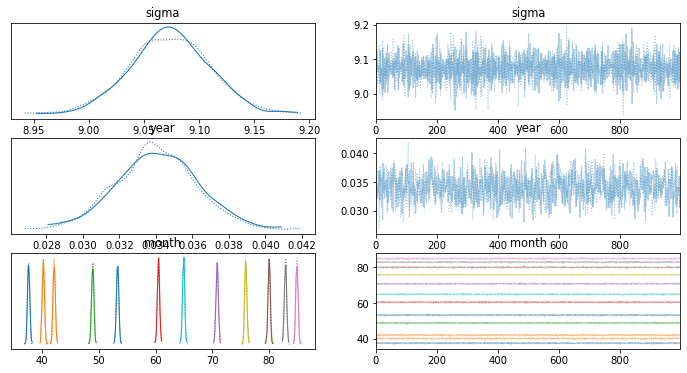

In [21]:
az.plot_trace(idata);

## Model 3. Year * Month Dummy Interaction

In [22]:
print(X_3_df.shape)
X_3_df.head()

(29964, 25)


,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_i_3,month_i_4,month_i_5,month_i_6,month_i_7,month_i_8,month_i_9,month_i_10,month_i_11,month_i_12
DATE,,,,,,,,,,,,,,,,,,,,,
1940-01-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-02,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-03,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-04,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1940-01-05,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
interaction_vars = list(X_3_df.columns[X_3_df.columns.str.startswith("month_i_")])
interaction_vars

['month_i_1',
 'month_i_2',
 'month_i_3',
 'month_i_4',
 'month_i_5',
 'month_i_6',
 'month_i_7',
 'month_i_8',
 'month_i_9',
 'month_i_10',
 'month_i_11',
 'month_i_12']

The following code fails to converge. Dot-operations to blame seems like. **But why???**

```python
with pm.Model() as model:

    sigma = pm.Exponential("sigma", lam=0.01)
    year_coeff = pm.Normal("year", 1.0, sigma=20)
    month_coeff = pm.Normal("month", 1.0, sigma=20, shape=len(month_vars))
    month_i_coeff = pm.Normal("month_i", 1.0, sigma=20, shape=len(interaction_vars))

    mu = (
        year_coeff * X_3_df.year.values 
        # Another way: (X_3_df[month_vars].values * month_coeff).sum(axis=-1)
        + pm.math.dot(X_3_df[month_vars].values, month_coeff)
        + pm.math.dot(X_3_df[interaction_vars].values, month_i_coeff)
    )

    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=w_df.temp)

    idata = pm.sample(tune=1000)  # , nuts={'target_accept':0.95}
```

The resulting error message:

```python
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3958 seconds.
The acceptance probability does not match the target. It is 0.9149, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 789 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3427, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
```

## Model 3. Year * Month Dummy Interaction. Attempt #2: no dot-ops

We can get rid of dot-multiply operations to make the model converge. 

In [24]:
X_3_v2_df = w_df[["year"]].assign(month=lambda df: df.index.month-1)
print(X_3_v2_df.shape)
X_3_v2_df.head()

(29964, 2)


,year,month
DATE,,
1940-01-01,0,0
1940-01-02,0,0
1940-01-03,0,0
1940-01-04,0,0
1940-01-05,0,0


In [25]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", lam=0.01)
    year_coeff = pm.Normal("year", 1.0, sigma=20)
    month_coeff = pm.Normal("month", 1.0, sigma=20, shape=len(month_vars))
    month_i_coeff = pm.Normal("month_i", 1.0, sigma=20, shape=len(interaction_vars))

    mu = (
        year_coeff * X_3_v2_df.year.values + month_coeff[X_3_v2_df['month'].values] + 
        # not exactly the statsmodels version...
        X_2_df.year.values * month_i_coeff[X_3_v2_df['month'].values]
    )

    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=w_df.temp)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vshulyak/opt/miniconda3/envs/intuitive_bayes/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, year, month, month_i]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1880 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 815 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2643, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,9.101,0.041,9.022,9.135,0.024,0.019,3.378,163.671,2.056
year,-3.586,1.840,-7.139,0.362,0.942,0.725,4.643,17.707,2.061
month[0],37.612,0.288,36.935,38.024,0.094,0.069,14.159,152.582,1.878
month[1],39.669,0.353,38.883,40.076,0.160,0.121,4.863,68.631,2.145
month[2],48.472,0.295,47.827,48.886,0.104,0.076,8.137,196.051,2.064
month[3],60.535,0.280,59.852,60.988,0.059,0.042,41.483,193.663,1.818
month[4],71.345,0.331,70.578,71.699,0.149,0.113,5.467,328.542,1.913
month[5],80.015,0.471,79.616,80.893,0.285,0.228,3.114,26.528,1.832
month[6],85.068,0.261,84.556,85.655,0.013,0.009,337.137,114.669,1.934
month[7],82.856,0.253,82.342,83.422,0.011,0.007,280.825,111.415,1.803


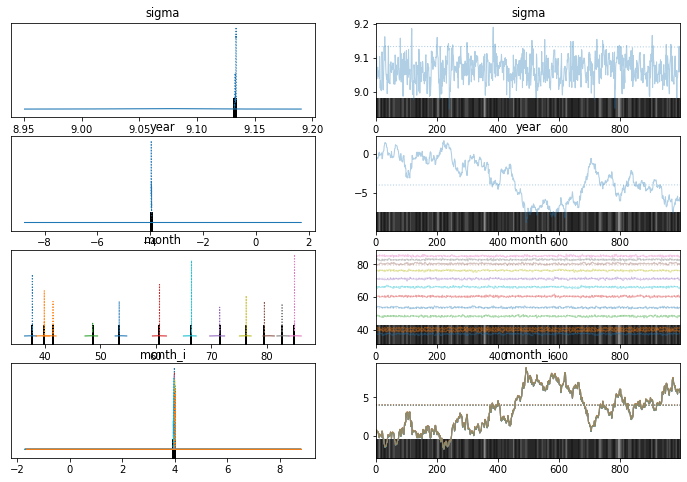

In [27]:
az.plot_trace(idata);

## Model 3. Year * Month Dummy Interaction. Attempt #3: Pooled Hierarchy

With inspiration from here https://vincentk1991.github.io/Bayesian-regression-tutorial/#regression-with-confounds

In [28]:
X_3_v3_df = w_df[["year"]].assign(month=lambda df: df.index.month-1)
print(X_3_v3_df.shape)
X_3_v3_df.head()

(29964, 2)


,year,month
DATE,,
1940-01-01,0,0
1940-01-02,0,0
1940-01-03,0,0
1940-01-04,0,0
1940-01-05,0,0


In [29]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", lam=0.01)
    month_coeff = pm.Normal("month", 1.0, sigma=20, shape=len(month_vars))

    pooled_year_mu = pm.Normal("pooled_year_mu",1.0, sigma=20)
    pooled_year_sigma = pm.Exponential("pooled_year_sigma",lam=0.01)

    month_i_coeff = pm.Normal("month_i", 
                              pooled_year_mu, 
                              sigma=pooled_year_sigma, 
                              shape=len(interaction_vars))

    mu = (
        month_coeff[X_3_v3_df['month'].values] + 
        X_3_v3_df['year'].values * month_i_coeff[X_3_v3_df['month'].values]
    )

    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=w_df.temp)

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vshulyak/opt/miniconda3/envs/intuitive_bayes/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, month, pooled_year_mu, pooled_year_sigma, month_i]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 60 seconds.


In [30]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,9.069,0.037,9.002,9.138,0.001,0.000,3783.973,1479.063,1.001
month[0],37.521,0.323,36.937,38.157,0.005,0.004,3779.854,1756.588,1.000
month[1],39.628,0.354,38.973,40.290,0.006,0.004,3377.689,1481.174,1.002
month[2],48.423,0.328,47.850,49.081,0.006,0.004,3343.403,1606.319,1.003
month[3],60.457,0.322,59.818,61.021,0.005,0.004,3663.862,1551.312,1.001
month[4],71.085,0.334,70.456,71.724,0.005,0.004,3790.595,1333.317,1.005
month[5],80.312,0.330,79.683,80.911,0.006,0.004,3376.450,1410.057,1.000
month[6],85.062,0.341,84.377,85.684,0.006,0.004,3784.831,1406.250,0.999
month[7],82.939,0.333,82.366,83.644,0.006,0.004,3646.877,1436.783,1.000
month[8],76.157,0.333,75.536,76.764,0.006,0.004,3407.643,1405.044,1.000


**Result:** `pooled_year_mu = 0.034`, which is again very close to what we used to get. **The model doesn't diverge!** 

However, interaction variables do not look the same. By looking at credible intervals, we could assume the `month_i[9]` variable doesn't have any effect as it includes 0. `month_i[11]` has the highest value, which agrees with the statsmodels version. However, we can't still make the same conclusions here... 

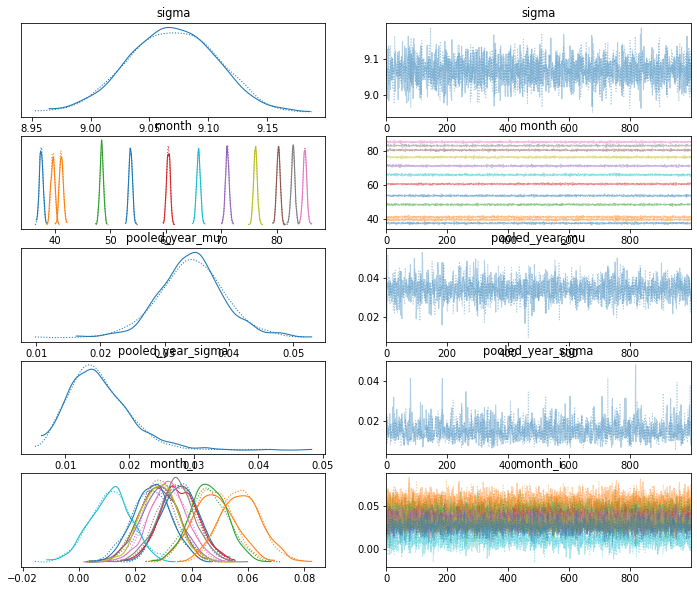

In [31]:
az.plot_trace(idata);

# Questions:

1. How do I get the same results as in the blog for the statsmodels model? The author used p-values for `month_i_X` interaction variables to make conclusions about temprerature increase.
2. PyMC model takes longer to sample (not a complaint). What additional benefit to this analysis PyMC can bring? It's exactly not a prediction accuracy problem, rather inference/causality problem.
3. Why does `pm.math.dot` make the model diverge when the model becomes reasonably big?
4. Is this the type of problem where hierarchy could be applied (like it's done in the attempt #3)?
5. Any improvements on reasoning to come to more sound conclusions?